# Import

In [1]:
import os
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import numpy as np

import random
from fastcore.all import dict2obj
import json

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.models import load_model

from sklearn.metrics import confusion_matrix , classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.preprocessing.image import load_img
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Conv2D , MaxPooling2D , Dense , BatchNormalization , Dropout,Flatten , Activation, GlobalAveragePooling2D
from keras.optimizers import Adam , Adamax
from keras.utils import to_categorical
from keras import regularizers

2024-03-20 16:35:03.201985: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-20 16:35:03.202133: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-20 16:35:03.359592: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Define Constansts

In [2]:
FAST_RUN = False
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
BATCH_SIZE = 64
NUM_CLASSES=120

lable_enconder = LabelEncoder()

# Data

## Loading and Unzip Data

In [3]:
df = pd.read_csv("/kaggle/input/dog-breed-identification/labels.csv")

In [4]:
train_dir = "/kaggle/input/dog-breed-identification/train"
test_dir = "/kaggle/input/dog-breed-identification/test"

In [5]:
img_list = os.listdir(train_dir)

In [6]:
len(img_list)

10222

In [7]:
df

id                     breed
0      000bec180eb18c7604dcecc8fe0dba07               boston_bull
1      001513dfcb2ffafc82cccf4d8bbaba97                     dingo
2      001cdf01b096e06d78e9e5112d419397                  pekinese
3      00214f311d5d2247d5dfe4fe24b2303d                  bluetick
4      0021f9ceb3235effd7fcde7f7538ed62          golden_retriever
...                                 ...                       ...
10217  ffd25009d635cfd16e793503ac5edef0                    borzoi
10218  ffd3f636f7f379c51ba3648a9ff8254f            dandie_dinmont
10219  ffe2ca6c940cddfee68fa3cc6c63213f                  airedale
10220  ffe5f6d8e2bff356e9482a80a6e29aac        miniature_pinscher
10221  fff43b07992508bc822f33d8ffd902ae  chesapeake_bay_retriever

[10222 rows x 2 columns]

In [8]:
breed=list(df["breed"].value_counts().keys())
len(breed)

120

In [9]:
new=sorted(breed,reverse=True)[: NUM_CLASSES]
len(new)

120

In [10]:
df=df.query("breed in @new")
df

id                     breed
0      000bec180eb18c7604dcecc8fe0dba07               boston_bull
1      001513dfcb2ffafc82cccf4d8bbaba97                     dingo
2      001cdf01b096e06d78e9e5112d419397                  pekinese
3      00214f311d5d2247d5dfe4fe24b2303d                  bluetick
4      0021f9ceb3235effd7fcde7f7538ed62          golden_retriever
...                                 ...                       ...
10217  ffd25009d635cfd16e793503ac5edef0                    borzoi
10218  ffd3f636f7f379c51ba3648a9ff8254f            dandie_dinmont
10219  ffe2ca6c940cddfee68fa3cc6c63213f                  airedale
10220  ffe5f6d8e2bff356e9482a80a6e29aac        miniature_pinscher
10221  fff43b07992508bc822f33d8ffd902ae  chesapeake_bay_retriever

[10222 rows x 2 columns]

In [11]:
df['id'] = df['id'] + '.jpg'

In [12]:
df

id                     breed
0      000bec180eb18c7604dcecc8fe0dba07.jpg               boston_bull
1      001513dfcb2ffafc82cccf4d8bbaba97.jpg                     dingo
2      001cdf01b096e06d78e9e5112d419397.jpg                  pekinese
3      00214f311d5d2247d5dfe4fe24b2303d.jpg                  bluetick
4      0021f9ceb3235effd7fcde7f7538ed62.jpg          golden_retriever
...                                     ...                       ...
10217  ffd25009d635cfd16e793503ac5edef0.jpg                    borzoi
10218  ffd3f636f7f379c51ba3648a9ff8254f.jpg            dandie_dinmont
10219  ffe2ca6c940cddfee68fa3cc6c63213f.jpg                  airedale
10220  ffe5f6d8e2bff356e9482a80a6e29aac.jpg        miniature_pinscher
10221  fff43b07992508bc822f33d8ffd902ae.jpg  chesapeake_bay_retriever

[10222 rows x 2 columns]

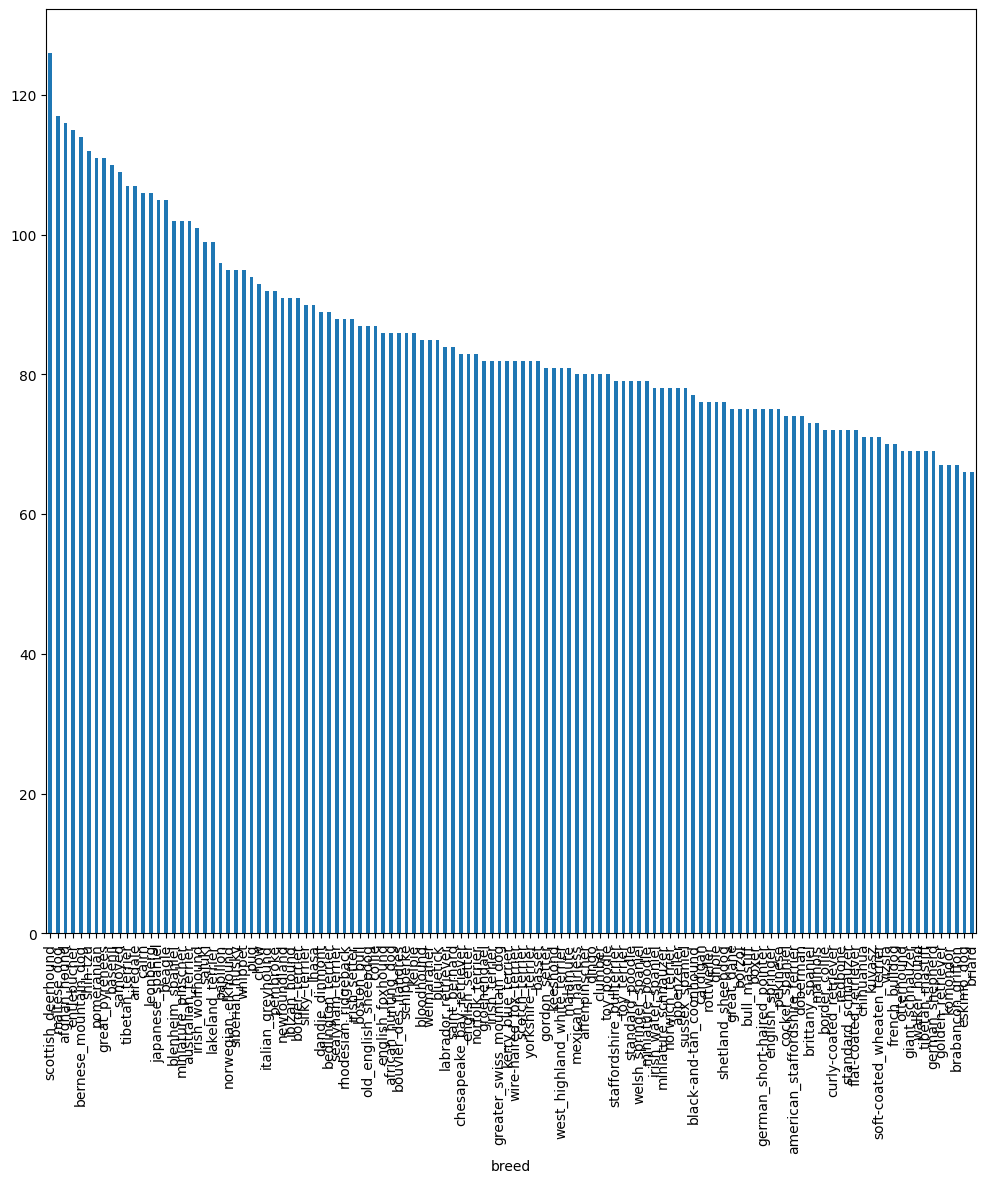

In [13]:
df['breed'].value_counts().plot.bar(figsize=(12, 12))
plt.show()

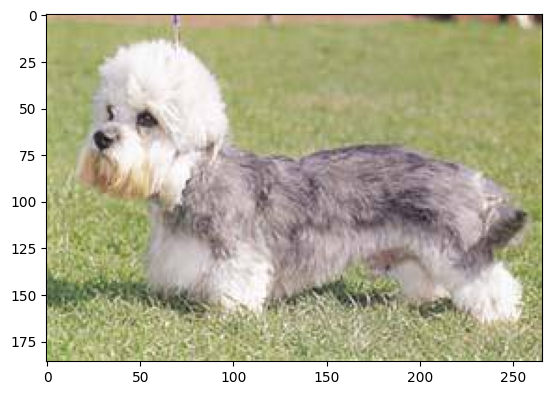

In [14]:
sample_image = random.choice(img_list)
image_path = train_dir + '/' + sample_image
image = load_img(image_path)
plt.imshow(image)

In [15]:
# # Define the directory where your test images are located
# test_dir = '/kaggle/input/dog-breed-identification/test'

# # Get the list of image file names in the test directory
# test_files = os.listdir(test_dir)

# # Initialize an empty array to store preprocessed test images
# test_data = np.zeros((len(test_files), IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS), dtype="float32")

# # Iterate over each image file
# for i, img_file in enumerate(test_files):
#     # Read the image
#     img = cv2.imread(os.path.join(test_dir, img_file), cv2.IMREAD_COLOR)
#     # Resize the image to the desired dimensions
#     img_resized = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT))
#     # Preprocess the image (e.g., normalize pixel values)
#     img_preprocessed = preprocess_input(np.expand_dims(np.array(img_resized[..., ::-1].astype(np.float32)), axis=0))
#     # Store the preprocessed image in the array
#     test_data[i] = img_preprocessed

# # Print the shape of the preprocessed test data
# print("Shape of preprocessed test data:", test_data.shape)

In [16]:
# train_data=np.zeros((len(df),IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS),dtype="float32")
# for i,img_id in enumerate(df["id"]):
#     img=cv2.resize(cv2.imread(train_dir + '/' + img_id,cv2.IMREAD_COLOR),((IMAGE_WIDTH,IMAGE_HEIGHT)))
#     img_array=preprocess_input(np.expand_dims(np.array(img[...,: : -1].astype(np.float32)).copy(),axis=0))
#     train_data[i]=img_array

In [17]:
train_data = np.load('/kaggle/input/dog-breed-identification-hungto/train_data.npy', mmap_mode='r')
test_data = np.load('/kaggle/input/dog-breed-identification-hungto/test_data.npy', mmap_mode='r')

In [18]:
train_data.shape

(10222, 224, 224, 3)

In [19]:
label_data = lable_enconder.fit_transform(df["breed"].values)
label_data.shape

(10222,)

In [20]:
X_train, X_validate, y_train, y_validate = train_test_split(train_data, label_data, test_size=0.2, random_state=42)

In [21]:
print("Train Data Shape :",X_train.shape)
print("Train Label Data Shape :",y_train.shape)
print("Test Data Shape :",X_validate.shape)
print("Test Label Data Shape :",y_validate.shape)

Train Data Shape : (8177, 224, 224, 3)
Train Label Data Shape : (8177,)
Test Data Shape : (2045, 224, 224, 3)
Test Label Data Shape : (2045,)


# Data Agumentation

In [22]:
train_datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = train_datagen.flow(X_train, 
                                     y_train, 
                                     batch_size=BATCH_SIZE)

In [23]:
validate_datagen = ImageDataGenerator()
validate_generator = validate_datagen.flow(X_validate, 
                                     y_validate, 
                                     batch_size=BATCH_SIZE)

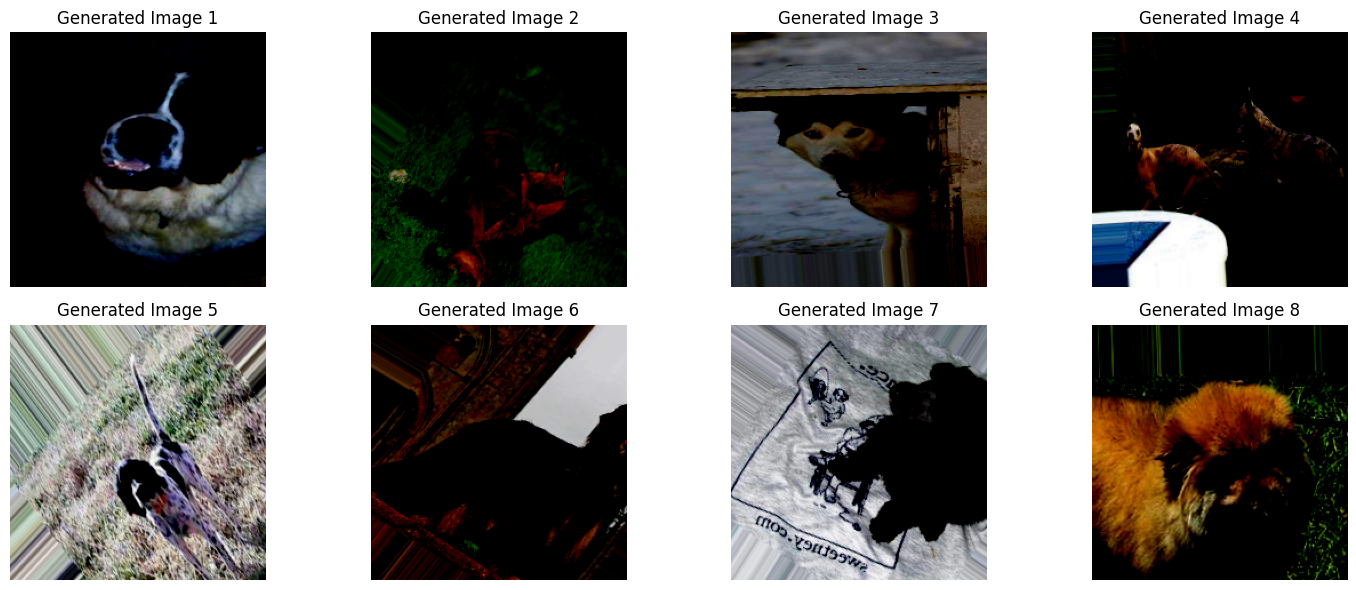

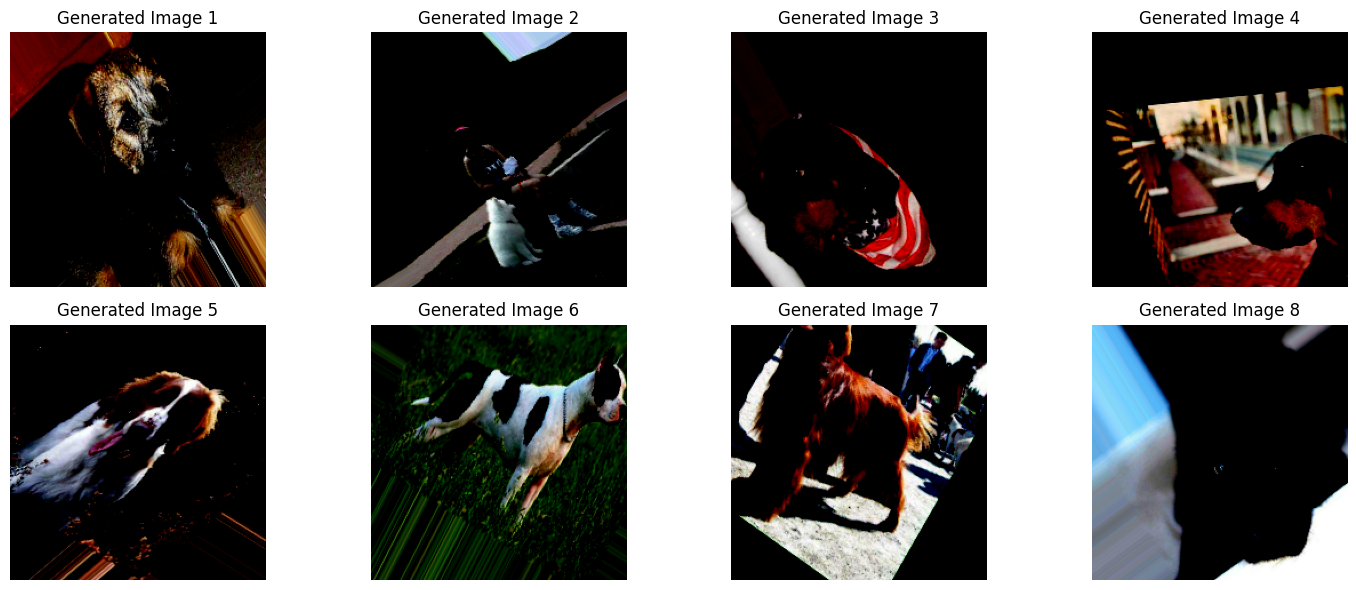

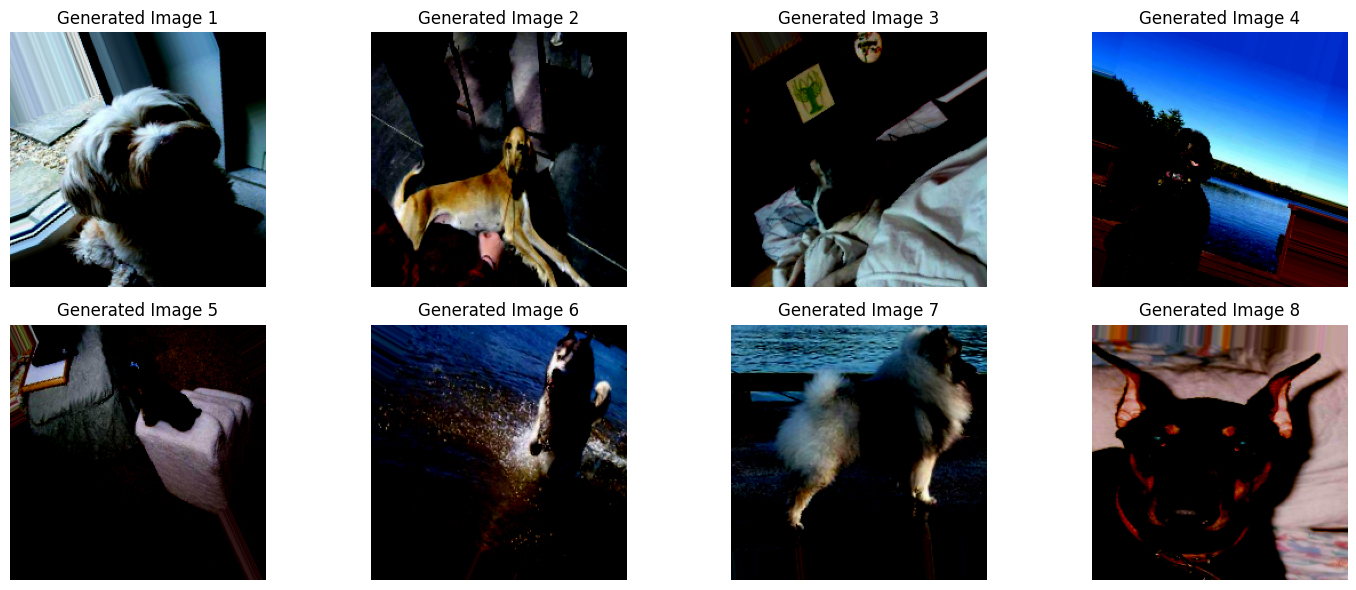

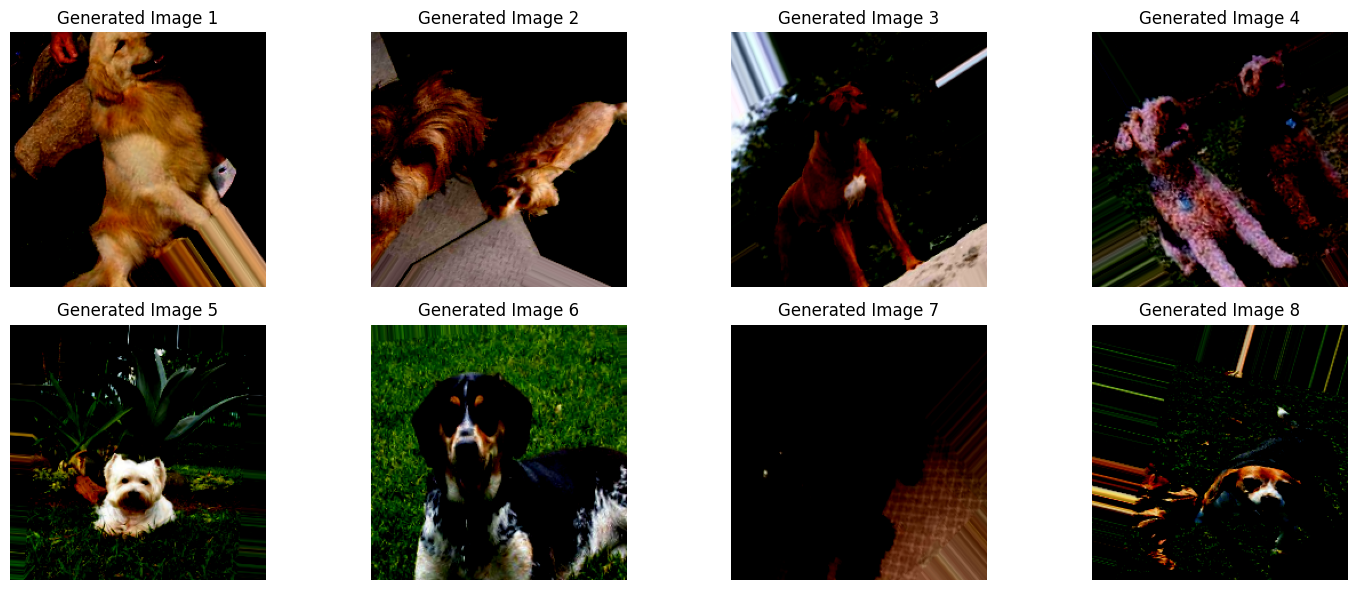

In [24]:
# Define the number of batches and images per batch to generate
num_batches = 4
images_per_batch = 8

# Generate and plot images
for _ in range(num_batches):
    # Generate a batch of images and labels from the train_generator
    images, labels = next(train_generator)
    
    # Plot the images in the batch
    plt.figure(figsize=(15, 6))
    for i in range(images_per_batch):
        plt.subplot(2, images_per_batch//2, i+1)
        plt.imshow(images[i])
        plt.title('Generated Image {}'.format(i+1))
        plt.axis('off')  # Turn off axis labels
    plt.tight_layout()
    plt.show()

# Callback

In [25]:
# earlystop = EarlyStopping(monitor = 'val_loss',
#                           min_delta = 0.001,
#                           patience = 10,
#                           verbose = 1)

In [26]:
# learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
#                                             patience=2,
#                                             verbose=1,
#                                             factor=0.5,
#                                             min_lr=0.00001)

## Define callbacks list

In [27]:
# callbacks = [learning_rate_reduction]

# Build Model

In [28]:
nasNetLarge = tf.keras.applications.NASNetLarge(
                  weights='imagenet',
                  include_top=False,
                  input_shape=[IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS]
               )

for layer in nasNetLarge.layers:
    layer.trainable = False
nasNetLarge.summary()

343610240/343610240 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "NASNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv1 (Conv2D) │ (None, 111, 111,  │      2,592 │ input_layer[0][0] │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn1            │ (None, 111, 111,  │        384 │ stem_conv1[0][0]  │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ stem_bn1[0][0]    │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduction_conv_1_s… │ (None, 111, 111,  │      4,032 │ activation[0][0]  │
│ (Conv2D)            │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduction_bn_1_ste… │ (None, 111, 111,  │        168 │ reduction_conv_1… │
│ (BatchNormalizatio… │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 111, 111,  │          0 │ reduction_bn_1_s… │
│ (Activation)        │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 111, 111,  │          0 │ stem_bn1[0][0]    │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_p… │ (None, 115, 115,  │          0 │ activation_1[0][… │
│ (ZeroPadding2D)     │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_p… │ (None, 117, 117,  │          0 │ activation_3[0][… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_r… │ (None, 56, 56,    │      2,814 │ separable_conv_1… │
│ (SeparableConv2D)   │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_r… │ (None, 56, 56,    │      8,736 │ separable_conv_1… │
│ (SeparableConv2D)   │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_b… │ (None, 56, 56,    │        168 │ separable_conv_1… │
│ (BatchNormalizatio… │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_b… │ (None, 56, 56,    │        168 │ separable_conv_1… │
│ (BatchNormalizatio… │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 56, 56,    │          0 │ separable_conv_1… │
│ (Activation)        │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 56, 56,    │          0 │ separable_conv_1… │
│ (Activation)        │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_2_r… │ (None, 56, 56,    │      2,814 │ activation_2[0][

 Total params: 84,916,818 (323.93 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 84,916,818 (323.93 MB)

In [29]:
model = Sequential()

model.add(nasNetLarge)
# model.trainable= True;

model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
# model.add(Flatten()) # Add a Flatten layer to convert 2D feature maps to 1D vectors
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
# model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(120, activation='softmax'))

learning_rate = 1e-3

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=['accuracy'])
# Now the model can be built, and summary can be printed
model.build((None, IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ NASNet (Functional)             │ (None, 7, 7, 4032)     │    84,916,818 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 4032)     │        16,128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 4032)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     4,129,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 120)            │        30,840 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,750,730 (342.37 MB)

 Trainable params: 4,825,336 (18.41 MB)

 Non-trainable params: 84,925,394 (323.96 MB)

In [30]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validate_generator,
    validation_steps=X_validate.shape[0]//BATCH_SIZE,
    steps_per_epoch=X_train.shape[0]//BATCH_SIZE,
    callbacks=ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1710952745.162371     110 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1710952745.470683     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 82/127 ━━━━━━━━━━━━━━━━━━━━ 29s 656ms/step - accuracy: 0.3651 - loss: 3.2915

W0000 00:00:1710952842.202727     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4341 - loss: 2.8997

W0000 00:00:1710952891.805816     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


127/127 ━━━━━━━━━━━━━━━━━━━━ 250s 1s/step - accuracy: 0.4353 - loss: 2.8930 - val_accuracy: 0.8332 - val_loss: 0.6126 - learning_rate: 0.0010
Epoch 2/50
  1/127 ━━━━━━━━━━━━━━━━━━━━ 1:32 733ms/step - accuracy: 0.7656 - loss: 1.3776

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
W0000 00:00:1710952953.048573     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 317ms/step - accuracy: 0.7656 - loss: 1.3776 - val_accuracy: 0.7705 - val_loss: 0.8576 - learning_rate: 0.0010
Epoch 3/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 114s 859ms/step - accuracy: 0.7096 - loss: 1.2357 - val_accuracy: 0.8448 - val_loss: 0.5918 - learning_rate: 0.0010
Epoch 4/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6875 - loss: 1.2723 - val_accuracy: 0.8852 - val_loss: 0.5211 - learning_rate: 0.0010
Epoch 5/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 114s 858ms/step - accuracy: 0.7285 - loss: 1.1110 - val_accuracy: 0.8528 - val_loss: 0.5675 - learning_rate: 0.0010
Epoch 6/50
  1/127 ━━━━━━━━━━━━━━━━━━━━ 1:26 689ms/step - accuracy: 0.7344 - loss: 1.0411
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7344 - loss: 1.0411 - val_accuracy: 0.7705 - val_loss: 0.6896 - learning_rate: 0.0010
Epoch 7/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 113s 858ms/step - accuracy: 0.7569 - loss: 0.

In [36]:
# # Save the model to the /kaggle/working/ directory
model.save_weights('/kaggle/working/w.weights.h5')

In [38]:
# Check if history file exists, and delete it if it does
history_file_path = '/kaggle/working/history.json'
if os.path.exists(history_file_path):
    os.remove(history_file_path)

# Save the history to a JSON file
with open(history_file_path, 'w') as f:
    json.dump(history.history, f)

# Model Evaluation

## Visualize train, validation accuracy 

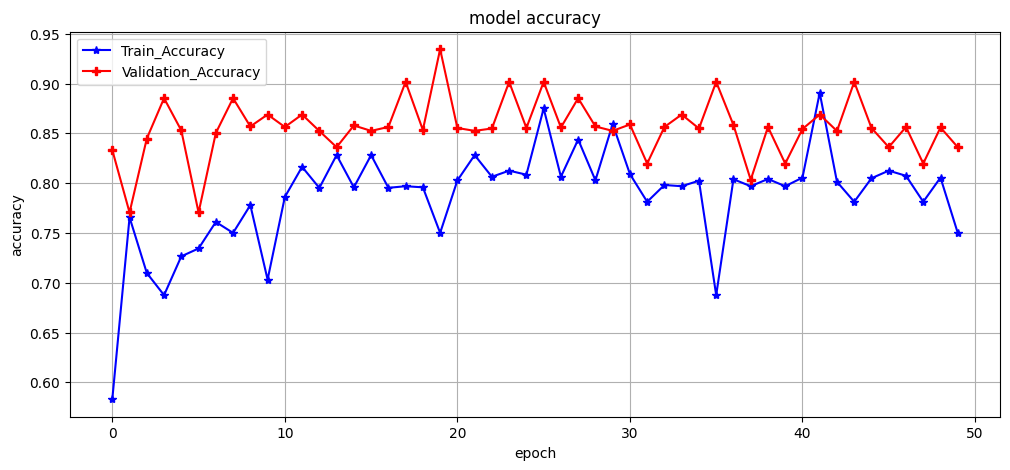

In [39]:
plt.figure(figsize=(12,5))
plt.plot(history.history['accuracy'],label="Train_Accuracy",color="blue",marker="*")
plt.plot(history.history['val_accuracy'],label="Validation_Accuracy",color="red",marker="P")
plt.grid(True)
plt.legend()
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

## Visualize train, validation loss

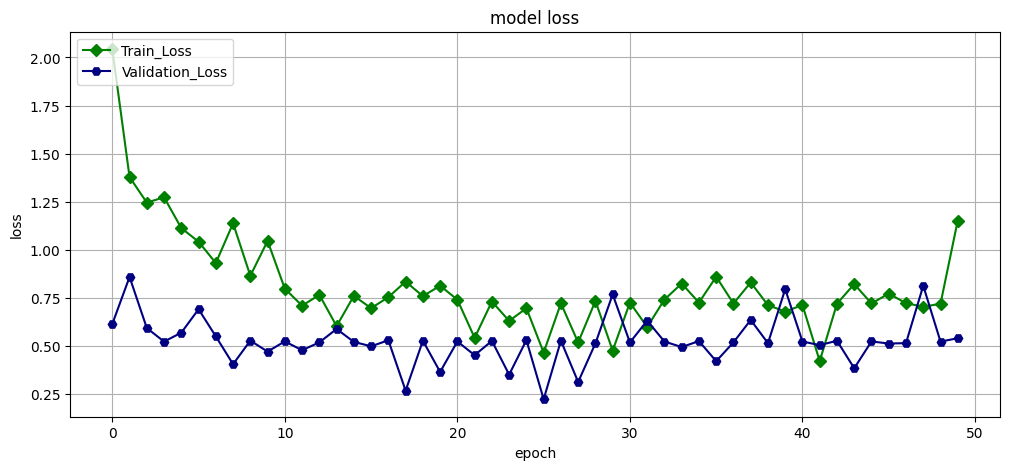

In [45]:
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'],color="green",marker="D")
plt.plot(history.history['val_loss'],color="navy",marker="H")
plt.grid(True)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train_Loss', 'Validation_Loss'], loc='upper left')
plt.show()

In [40]:
score = model.evaluate(validate_generator,batch_size=BATCH_SIZE)
print("Accuracy: {:.2f}%".format(score[1] * 100)) 
print("Loss: ",score[0])

32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 725ms/step - accuracy: 0.8643 - loss: 0.4651
Accuracy: 85.57%
Loss:  0.5221405029296875


# Evaluate on Validation dataset

In [47]:
lab = df["breed"].unique().tolist()

In [49]:
pre=model.predict(X_validate)
predict=np.argmax(pre,axis=1)

64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 330ms/step


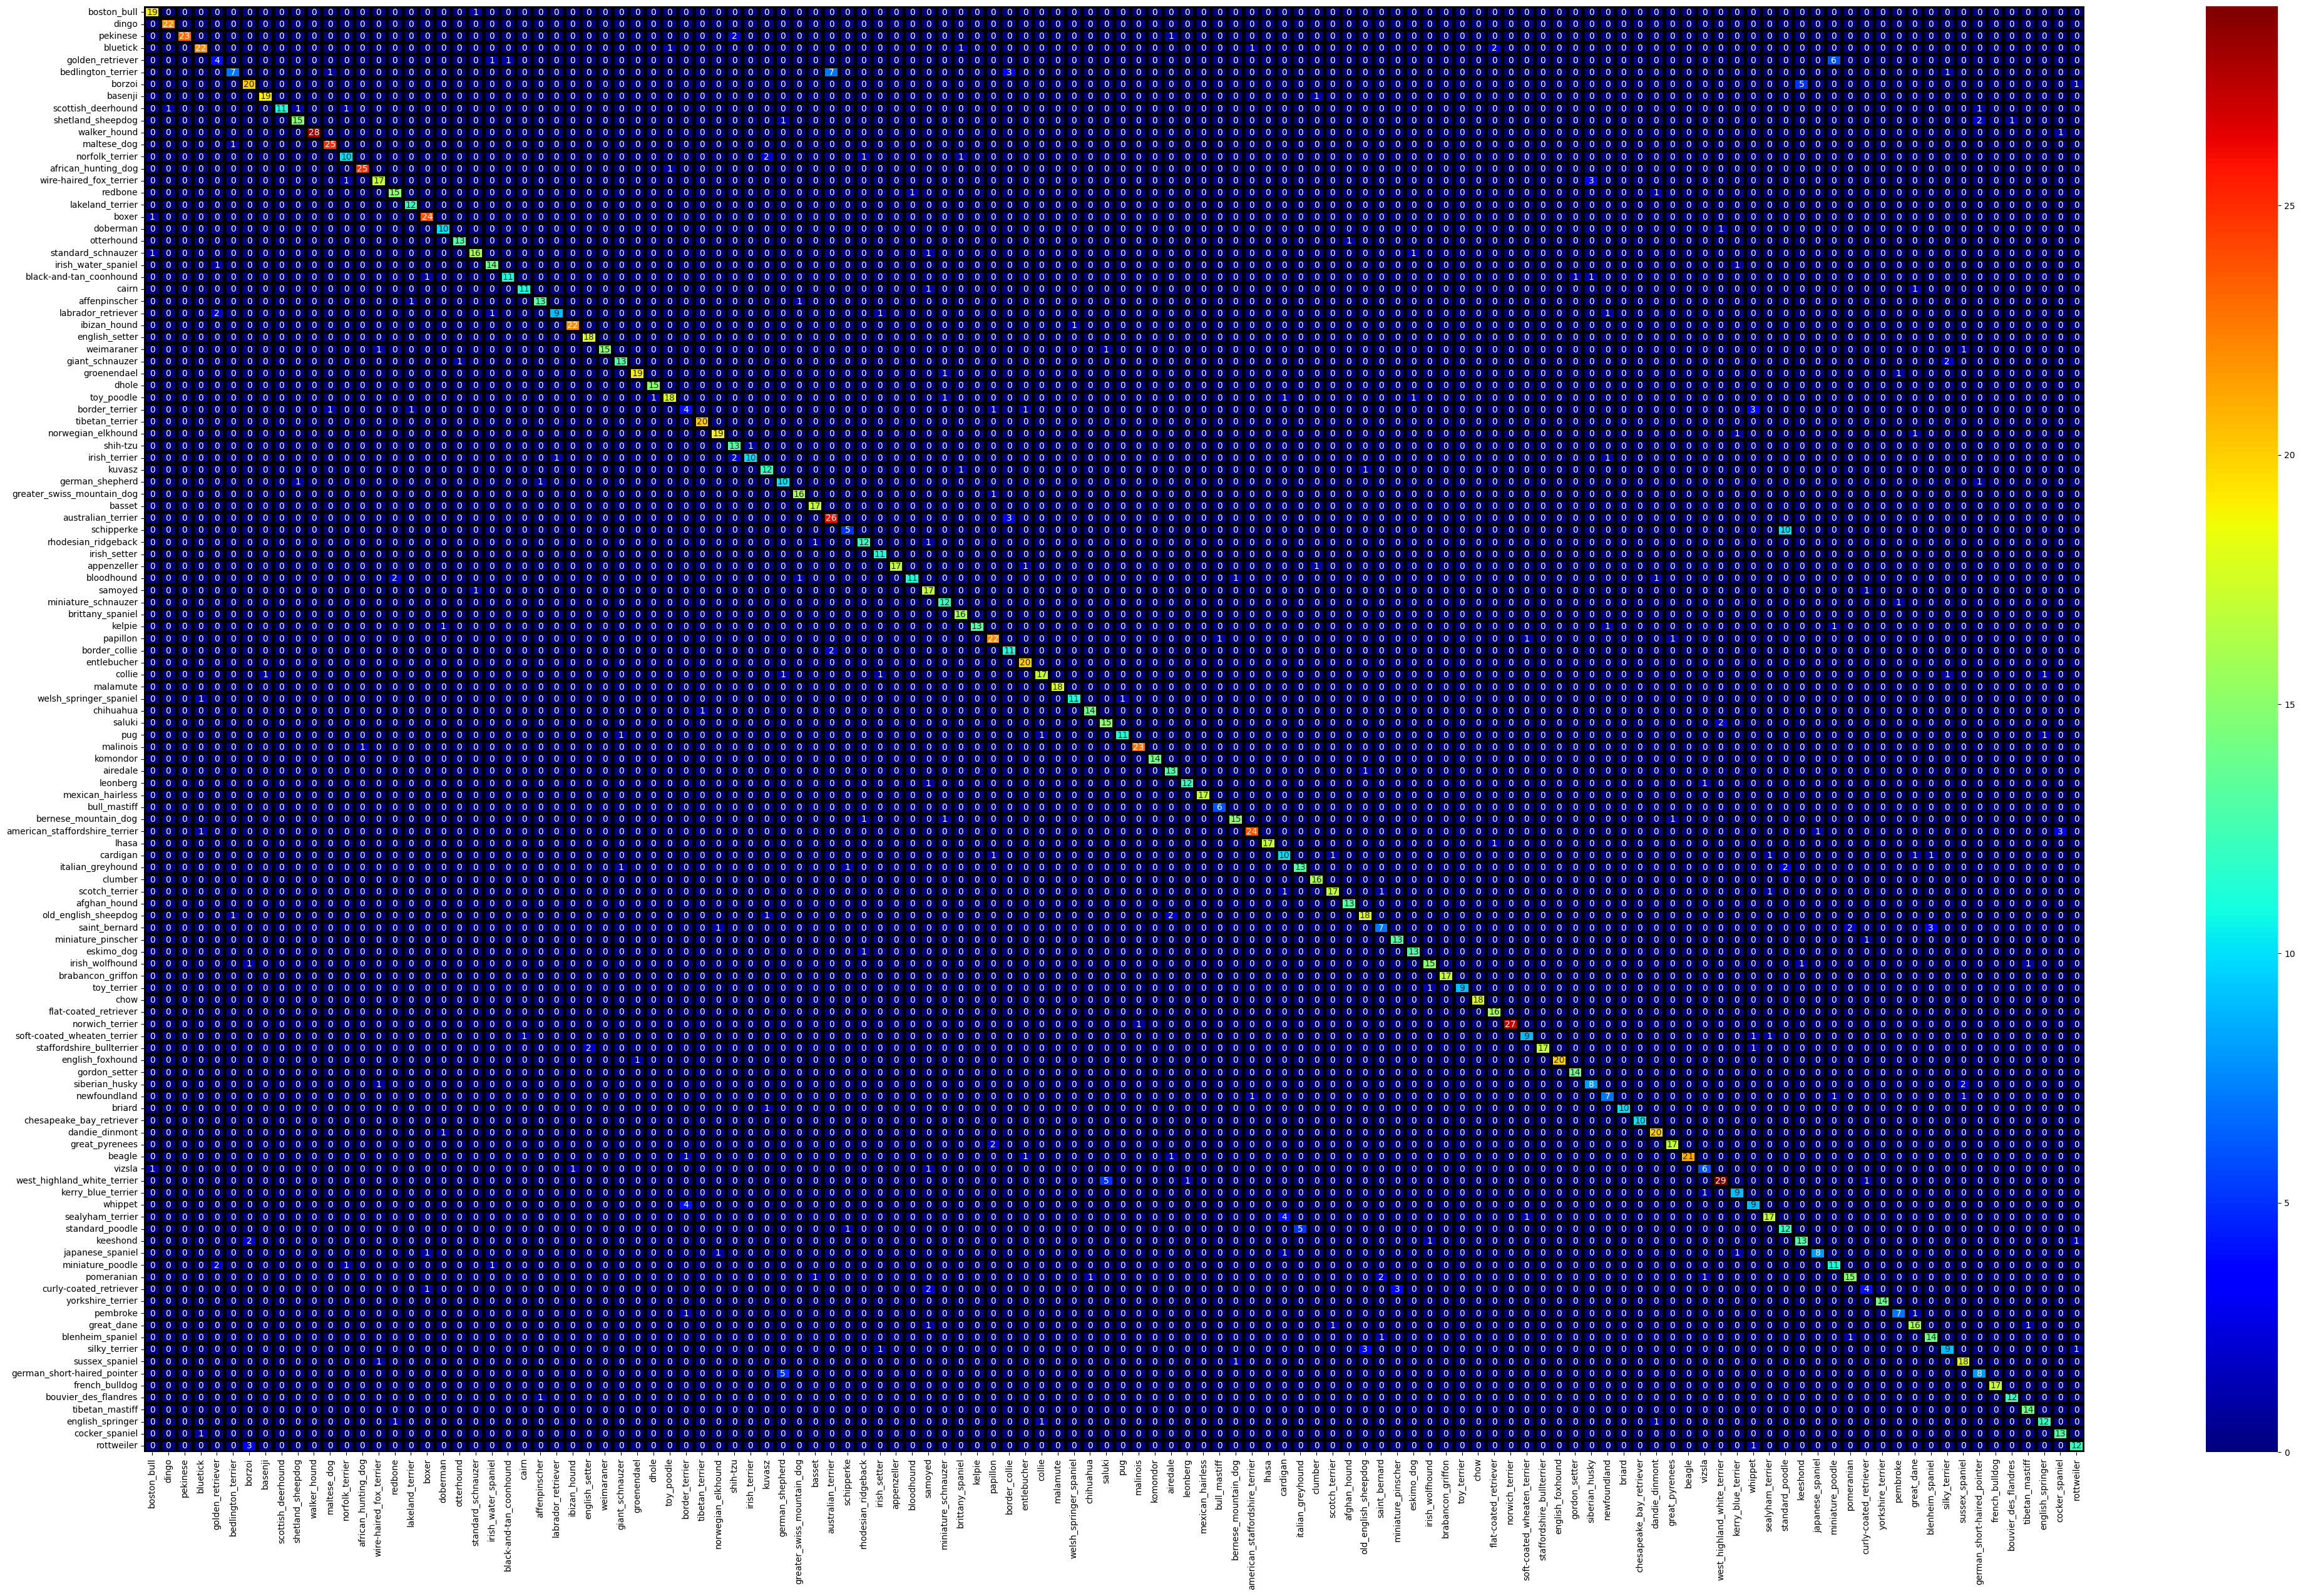

In [50]:
from sklearn.metrics import confusion_matrix, classification_report
plt.figure(figsize=(50,30))
cf = confusion_matrix(y_validate,predict)
sns.heatmap(cf,annot=True,fmt="d",cmap="jet",lw=4,linecolor="black",xticklabels=lab,yticklabels=lab)
plt.show()

In [52]:
report = classification_report(y_validate,predict,target_names=lab)

## Top breeds have the highest precision in prediction

In [140]:
breeds = []
precisions = []
report_lines = report.strip().split('\n')

In [141]:
for line in report_lines[2:len(report_lines)-3]:
    parts = line.strip().split()
    if(len(parts) >= 5): 
        breeds.append(parts[0])
        precisions.append(float(parts[1]))

In [142]:
# Create a dictionary mapping breeds to precision values
breed_precision_dict = dict(zip(breeds, precisions))

# Sort the breeds based on precision values
sorted_breeds = sorted(breed_precision_dict, key=breed_precision_dict.get, reverse=True)

# Extract the top 10 breeds with the highest precision
top_10_breeds = sorted_breeds[:30]

print("Top 10 breeds with the highest precision:")
for breed in top_10_breeds:
    print(f"{breed}: {breed_precision_dict[breed]}")

Top 10 breeds with the highest precision:
pekinese: 1.0
scottish_deerhound: 1.0
walker_hound: 1.0
weimaraner: 1.0
appenzeller: 1.0
kelpie: 1.0
malamute: 1.0
komondor: 1.0
mexican_hairless: 1.0
lhasa: 1.0
brabancon_griffon: 1.0
toy_terrier: 1.0
chow: 1.0
norwich_terrier: 1.0
staffordshire_bullterrier: 1.0
english_foxhound: 1.0
briard: 1.0
chesapeake_bay_retriever: 1.0
beagle: 1.0
yorkshire_terrier: 1.0
french_bulldog: 1.0
dingo: 0.96
african_hunting_dog: 0.96
ibizan_hound: 0.96
malinois: 0.96
basenji: 0.95
groenendael: 0.95
tibetan_terrier: 0.95
dhole: 0.94
maltese_dog: 0.93


In [143]:
b = df['breed'].value_counts()

In [144]:
breed_name_list = []
precision_list = []
for breed, count in b.items():
    breed_name_list.append(breed)
    precision_list.append(count)

In [145]:
# Create a dictionary mapping breeds to precision values
breed_fre_dict = dict(zip(breed_name_list, precision_list))

# Sort the breeds based on precision values
sorted_breeds_fre = sorted(breed_fre_dict, key=breed_fre_dict.get, reverse=True)

# Extract the top 10 breeds with the highest precision
top_10_breeds_fre = sorted_breeds_fre[:30]

print("Top 10 breeds with the highest precision:")
for breed in top_10_breeds_fre:
    print(f"{breed}: {breed_fre_dict[breed]}")

Top 10 breeds with the highest precision:
scottish_deerhound: 126
maltese_dog: 117
afghan_hound: 116
entlebucher: 115
bernese_mountain_dog: 114
shih-tzu: 112
pomeranian: 111
great_pyrenees: 111
basenji: 110
samoyed: 109
tibetan_terrier: 107
airedale: 107
cairn: 106
leonberg: 106
japanese_spaniel: 105
beagle: 105
blenheim_spaniel: 102
miniature_pinscher: 102
australian_terrier: 102
irish_wolfhound: 101
saluki: 99
lakeland_terrier: 99
papillon: 96
norwegian_elkhound: 95
siberian_husky: 95
whippet: 95
pug: 94
chow: 93
italian_greyhound: 92
pembroke: 92


# Prediction

In [41]:
pred = model.predict(test_data)

  1/324 ━━━━━━━━━━━━━━━━━━━━ 3:04:42 34s/step

W0000 00:00:1710956310.788356     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


324/324 ━━━━━━━━━━━━━━━━━━━━ 167s 409ms/step


W0000 00:00:1710956443.013187     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [42]:
df_submission = pd.read_csv('/kaggle/input/dog-breed-identification/sample_submission.csv')
df_submission.head()

id  affenpinscher  afghan_hound  \
0  000621fb3cbb32d8935728e48679680e       0.008333      0.008333   
1  00102ee9d8eb90812350685311fe5890       0.008333      0.008333   
2  0012a730dfa437f5f3613fb75efcd4ce       0.008333      0.008333   
3  001510bc8570bbeee98c8d80c8a95ec1       0.008333      0.008333   
4  001a5f3114548acdefa3d4da05474c2e       0.008333      0.008333   

   african_hunting_dog  airedale  american_staffordshire_terrier  appenzeller  \
0             0.008333  0.008333                        0.008333     0.008333   
1             0.008333  0.008333                        0.008333     0.008333   
2             0.008333  0.008333                        0.008333     0.008333   
3             0.008333  0.008333                        0.008333     0.008333   
4             0.008333  0.008333                        0.008333     0.008333   

   australian_terrier   basenji    basset  ...  toy_poodle  toy_terrier  \
0            0.008333  0.008333  0.008333  ...    0.008333     0.008333   
1            0.008333  0.008333  0.008333  ...    0.008333     0.008333   
2            0.008333  0.008333  0.008333  ...    0.008333     0.008333   
3            0.008333  0.008333  0.008333  ...    0.008333     0.008333   
4            0.008333  0.008333  0.008333  ...    0.008333     0.008333   

     vizsla  walker_hound  weimaraner  welsh_springer_spaniel  \
0  0.008333      0.008333    0.008333                0.008333   
1  0.008333      0.008333    0.008333                0.008333   
2  0.008333      0.008333    0.008333                0.008333   
3  0.008333      0.008333    0.008333                0.008333   
4  0.008333      0.008333    0.008333                0.008333   

   west_highland_white_terrier   whippet  wire-haired_fox_terrier  \
0                     0.008333  0.008333                 0.008333   
1                     0.008333  0.008333                 0.008333   
2                     0.008333  0.008333                 0.008333   
3                     0.008333  0.008333                 0.008333   
4                     0.008333  0.008333                 0.008333   

   yorkshire_terrier  
0           0.008333  
1           0.008333  
2           0.008333  
3           0.008333  
4           0.008333  

[5 rows x 121 columns]

In [43]:
df_submission.iloc[:,1:] = pred
df_submission.head()

id  affenpinscher  afghan_hound  \
0  000621fb3cbb32d8935728e48679680e       0.000027  5.539254e-05   
1  00102ee9d8eb90812350685311fe5890       0.000403  5.714702e-05   
2  0012a730dfa437f5f3613fb75efcd4ce       0.000141  1.511643e-04   
3  001510bc8570bbeee98c8d80c8a95ec1       0.000020  3.004462e-05   
4  001a5f3114548acdefa3d4da05474c2e       0.000005  6.170749e-07   

   african_hunting_dog  airedale  american_staffordshire_terrier  \
0         3.552191e-06  0.000115                    6.352191e-07   
1         6.980788e-04  0.000169                    5.507481e-04   
2         2.128791e-05  0.000074                    2.822862e-05   
3         2.106556e-06  0.000135                    9.906089e-07   
4         2.793134e-07  0.000002                    1.349583e-05   

    appenzeller  australian_terrier       basenji    basset  ...  toy_poodle  \
0  5.950445e-06            0.000010  8.274440e-06  0.000038  ...    0.000010   
1  7.546894e-04            0.000095  1.696386e-03  0.000665  ...    0.000335   
2  2.193158e-05            0.000073  5.539183e-06  0.000015  ...    0.000063   
3  2.464964e-06            0.000004  4.314539e-06  0.000014  ...    0.000013   
4  2.920164e-07            0.000002  3.211782e-07  0.000003  ...    0.000008   

    toy_terrier    vizsla  walker_hound    weimaraner  welsh_springer_spaniel  \
0  1.181746e-05  0.000010      0.000006  4.292676e-05            7.672344e-06   
1  8.974915e-04  0.001642      0.000406  1.971297e-04            3.949008e-04   
2  1.066077e-05  0.000024      0.000013  1.989903e-05            1.072289e-05   
3  3.132707e-06  0.000005      0.000003  2.637663e-05            2.917265e-06   
4  8.887428e-07  0.000008      0.000001  9.518275e-07            5.629112e-07   

   west_highland_white_terrier   whippet  wire-haired_fox_terrier  \
0                 7.356966e-05  0.000012                 0.000030   
1                 5.007018e-04  0.002094                 0.000105   
2                 1.762489e-05  0.000025                 0.000139   
3                 2.727071e-05  0.000007                 0.000034   
4                 3.978894e-07  0.000003                 0.000013   

   yorkshire_terrier  
0           0.000051  
1           0.000051  
2           0.000086  
3           0.000013  
4           0.000001  

[5 rows x 121 columns]

In [44]:
final_df = df_submission.set_index('id')
final_df.to_csv('Submission.csv')